# Machine Learning for Fraud Detection

In [6]:
import numpy as np
import pandas as pd

import matplotlib
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.preprocessing import RobustScaler
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE

import optuna
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import average_precision_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numeric input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


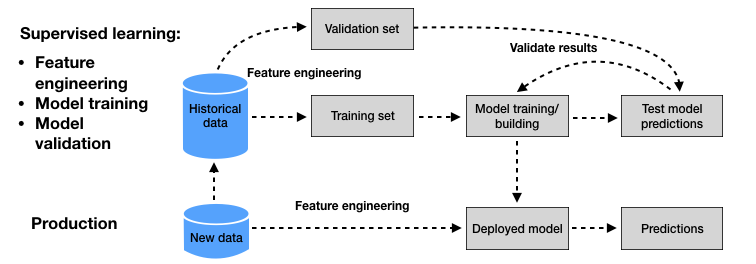

In [27]:
from IPython import display
display.Image("baseline_ML_workflow.png")

# Load the Data 

In [28]:
df_credit_card = pd.read_csv("./data/creditcard.csv")
df_credit_card

Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.018307  0.277838   
1      -0.082361 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672   
2       1.800499  0.791461  0.247676 -1.514654  ...  0.247998  0.771679   
3       1.247203  0.237609  0.377436 -1.387024  ... -0.108300  0.005274   
4       0.095921  0.592941 -0.270533  0.817739  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99   
...          ...       ...       ...       ...       ...       ...     ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[284807 rows x 31 columns]

# Data Preprocessing

In [9]:
# Time
seconds_per_day = 3600*24
df_credit_card["Day"] = df_credit_card["Time"].apply(lambda x: 1 if x<seconds_per_day else 2)
df_credit_card["Hour"] = df_credit_card["Time"].apply(lambda x: (x%seconds_per_day)//3600 + 1)

# Amount
def binning(row, list_columns):
    for i in range(len(list_columns)-1):
        if((row>=list_columns[i])&(row<list_columns[i+1])):
            return "{}-{}".format(list_columns[i], list_columns[i+1])
    return "{}+".format(list_columns[-1])

list_amounts = [0, 5, 10, 50, 100, 500, 1000]
df_credit_card["Amount_Group"] = df_credit_card.apply(lambda x: binning(x["Amount"], list_amounts), axis=1)
list_amounts = ["{}-{}".format(list_amounts[i], list_amounts[i+1]) for i in range(len(list_amounts)-1)]
list_amounts.append("1000+")
dict_amounts = dict(zip(list_amounts, range(len(list_amounts))))

df_credit_card

Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V24       V25  \
0       0.462388  0.239599  0.098698  0.363787  ...  0.066928  0.128539   
1      -0.082361 -0.078803  0.085102 -0.255425  ... -0.339846  0.167170   
2       1.800499  0.791461  0.247676 -1.514654  ... -0.689281 -0.327642   
3       1.247203  0.237609  0.377436 -1.387024  ... -1.175575  0.647376   
4       0.095921  0.592941 -0.270533  0.817739  ...  0.141267 -0.206010   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ... -0.509348  1.436807   
284803  1.058415  0.024330  0.294869  0.584800  ... -1.016226 -0.606624   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.640134  0.265745   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.123205 -0.569159   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.008797 -0.473649   

             V26       V27       V28  Amount  Class  Day  Hour  Amount_Group  
0      -0.189115  0.133558 -0.021053  149.62      0    1   1.0       100-500  
1       0.125895 -0.008983  0.014724    2.69      0    1   1.0           0-5  
2      -0.139097 -0.055353 -0.059752  378.66      0    1   1.0       100-500  
3      -0.221929  0.062723  0.061458  123.50      0    1   1.0       100-500  
4       0.502292  0.219422  0.215153   69.99      0    1   1.0        50-100  
...          ...       ...       ...     ...    ...  ...   ...           ...  
284802  0.250034  0.943651  0.823731    0.77      0    2  24.0           0-5  
284803 -0.395255  0.068472 -0.053527   24.79      0    2  24.0         10-50  
284804 -0.087371  0.004455 -0.026561   67.88      0    2  24.0        50-100  
284805  0.546668  0.108821  0.104533   10.00      0    2  24.0         10-50  
284806 -0.818267 -0.002415  0.013649  217.00      0    2  24.0       100-500  

[284807 rows x 34 columns]

# Feature Engineering 

In [10]:
scaler = RobustScaler()
df_credit_card["Amount_Scaled"] = scaler.fit_transform(df_credit_card['Amount'].values.reshape(-1, 1))
df_credit_card["Time_Scaled"] = scaler.fit_transform(df_credit_card['Time'].values.reshape(-1, 1))
df_credit_card

Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V26       V27  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.189115  0.133558   
1      -0.082361 -0.078803  0.085102 -0.255425  ...  0.125895 -0.008983   
2       1.800499  0.791461  0.247676 -1.514654  ... -0.139097 -0.055353   
3       1.247203  0.237609  0.377436 -1.387024  ... -0.221929  0.062723   
4       0.095921  0.592941 -0.270533  0.817739  ...  0.502292  0.219422   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.250034  0.943651   
284803  1.058415  0.024330  0.294869  0.584800  ... -0.395255  0.068472   
284804  3.031260 -0.296827  0.708417  0.432454  ... -0.087371  0.004455   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.546668  0.108821   
284806 -0.649617  1.577006 -0.414650  0.486180  ... -0.818267 -0.002415   

             V28  Amount  Class  Day  Hour  Amount_Group  Amount_Scaled  \
0      -0.021053  149.62      0    1   1.0       100-500       1.783274   
1       0.014724    2.69      0    1   1.0           0-5      -0.269825   
2      -0.059752  378.66      0    1   1.0       100-500       4.983721   
3       0.061458  123.50      0    1   1.0       100-500       1.418291   
4       0.215153   69.99      0    1   1.0        50-100       0.670579   
...          ...     ...    ...  ...   ...           ...            ...   
284802  0.823731    0.77      0    2  24.0           0-5      -0.296653   
284803 -0.053527   24.79      0    2  24.0         10-50       0.038986   
284804 -0.026561   67.88      0    2  24.0        50-100       0.641096   
284805  0.104533   10.00      0    2  24.0         10-50      -0.167680   
284806  0.013649  217.00      0    2  24.0       100-500       2.724796   

        Time_Scaled  
0         -0.994983  
1         -0.994983  
2         -0.994972  
3         -0.994972  
4         -0.994960  
...             ...  
284802     1.034951  
284803     1.034963  
284804     1.034975  
284805     1.034975  
284806     1.035022  

[284807 rows x 36 columns]

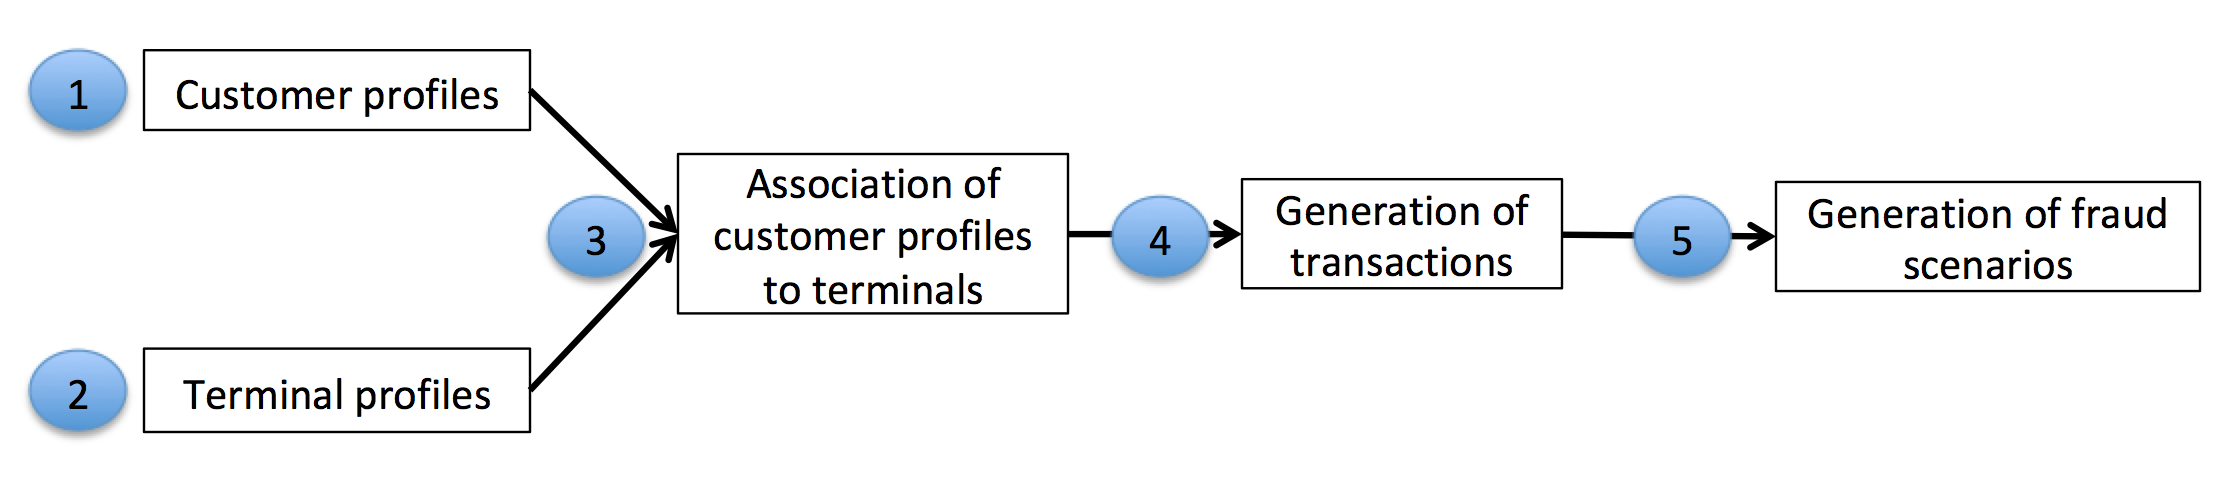

In [30]:
display.Image("FlowDatasetGenerator.png")

### Data Spliting

In [11]:
features = df_credit_card.drop(["Time", "Amount", "Day", "Hour", "Amount_Group", "Class"], axis=1)
labels = df_credit_card["Class"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=2023)
print("X_train Shape: {}".format(X_train.shape))
print(" X_test Shape: {}".format(X_test.shape))
print("y_train Shape: {}".format(y_train.shape))
print(" y_test Shape: {}".format(y_test.shape))

print('Labels y_train shape:', Counter(y_train))
print(' Labels y_test shape:', Counter(y_test))

X_train Shape: (227845, 30)
 X_test Shape: (56962, 30)
y_train Shape: (227845,)
 y_test Shape: (56962,)
Labels y_train shape: Counter({0: 227451, 1: 394})
 Labels y_test shape: Counter({0: 56864, 1: 98})


### Resampling (OneSidedSelection-SMOTE)

In [14]:
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=2023)
undersample_X_train, undersample_y_train = undersample.fit_resample(X_train, y_train)

print(undersample_X_train.shape)
print(undersample_y_train.shape)
print('Original dataset shape:', Counter(y_train))
print('Undersample dataset shape:', Counter(undersample_y_train))

oversample = SMOTE(sampling_strategy=0.5, random_state=2023)
resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)

print(resample_X_train.shape)
print(resample_y_train.shape)
print('Resample dataset shape:', Counter(resample_y_train))

(26557, 30)
(26557,)
Original dataset shape: Counter({0: 227451, 1: 394})
Undersample dataset shape: Counter({0: 26163, 1: 394})
(39244, 30)
(39244,)
Resample dataset shape: Counter({0: 26163, 1: 13081})


# Fraud Detection

In [15]:
def objective_lr(trial): 
    # Parameters
    params = {
        "C": trial.suggest_loguniform("C", 1e-7, 1e7),
        "tol" : trial.suggest_uniform("tol" , 1e-6 , 1e-3),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
        "random_state": 2023,
        "penalty": 'l2',
    }
    
    # Fit the Model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(resample_X_train, resample_y_train)
    
    # Make Predictions
    y_pred = optuna_model.predict(X_test)
    
    # Evaluate Predictions
    auc_pr = average_precision_score(y_test, y_pred)
    return auc_pr

In [16]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=2023))
study.optimize(objective_lr, n_trials=50)

[I 2023-01-22 19:33:16,999] A new study created in memory with name: no-name-89f684c8-71fa-4992-9788-f9cb4ad2a74f
[I 2023-01-22 19:33:17,053] Trial 0 finished with value: 0.5989116683872563 and parameters: {'C': 0.003219854565326339, 'tol': 0.0008905320293376914, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-22 19:33:17,105] Trial 1 finished with value: 0.013905425012794978 and parameters: {'C': 9.523073056581953e-06, 'tol': 0.0004684276966825911, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-22 19:33:17,225] Trial 2 finished with value: 0.5365451520132648 and parameters: {'C': 2.194940701351691, 'tol': 0.0005453903035716797, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-22 19:33:17,262] Trial 3 finished with value: 0.5639500008140991 and parameters: {'C': 0.03330885770369032, 'tol': 0.00015202113094260812, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5989116683872563.
[I 202

[I 2023-01-22 19:33:18,454] Trial 35 finished with value: 0.36833005032355975 and parameters: {'C': 1.1677316325307608e-06, 'tol': 0.0005779233394726718, 'solver': 'lbfgs'}. Best is trial 21 with value: 0.756133423421843.
[I 2023-01-22 19:33:18,486] Trial 36 finished with value: 0.5989116683872563 and parameters: {'C': 0.003183320269201743, 'tol': 0.0006573412671710501, 'solver': 'lbfgs'}. Best is trial 21 with value: 0.756133423421843.
[I 2023-01-22 19:33:18,537] Trial 37 finished with value: 0.01368112030164199 and parameters: {'C': 9.29011862915564e-06, 'tol': 0.0005029098189851691, 'solver': 'liblinear'}. Best is trial 21 with value: 0.756133423421843.
[I 2023-01-22 19:33:18,562] Trial 38 finished with value: 0.6992749041006046 and parameters: {'C': 0.00019477274531895693, 'tol': 0.0007403584588603219, 'solver': 'lbfgs'}. Best is trial 21 with value: 0.756133423421843.
[I 2023-01-22 19:33:18,619] Trial 39 finished with value: 0.019414253458223483 and parameters: {'C': 1.83036324726

In [17]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.756133423421843
  Params: 
    C: 1.3236779701996232e-05
    tol: 0.0005142118600947645
    solver: lbfgs


In [18]:
params = trial.params
best_score = 0
best_resample = {}

n_neighbors = [1, 2, 3, 4, 5]
smote_ratio = [0.35, 0.5, 0.75, 0.8, 1.0]

df_resample = pd.DataFrame()

print('Original dataset shape:', Counter(y_train))
for i in range(5):
    for j in range(5):
        print("N-Neighbors:", n_neighbors[i], "Smote Ratio:", smote_ratio[j])
        undersample = OneSidedSelection(n_neighbors=n_neighbors[i], n_seeds_S=200, random_state=2023)
        undersample_X_train, undersample_y_train = undersample.fit_resample(X_train, y_train)

        print('Undersample dataset shape:', Counter(undersample_y_train))

        oversample = SMOTE(sampling_strategy=smote_ratio[j], random_state=2023)
        resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)
        
        print('Resample dataset shape:', Counter(resample_y_train))
        
        model = LogisticRegression(random_state=2023, penalty="l2")
        model.set_params(**params)
        
        model.fit(resample_X_train, resample_y_train)

        # Make Predictions
        y_pred = model.predict(X_test)

        # Evaluate Predictions
        auc_pr = average_precision_score(y_test, y_pred)
        
        print("Score:", auc_pr)
        
        df_resample.loc[i*5+j, "n_neighbors"] = n_neighbors[i]
        df_resample.loc[i*5+j, "smote_ratio"] = smote_ratio[j]
        df_resample.loc[i*5+j, "AUC_PR (%)"] = round(auc_pr*100, 2)
        
        if(auc_pr>best_score):
            best_score = auc_pr
            best_resample["n_neighbors"] = n_neighbors[i]
            best_resample["smote_ratio"] = smote_ratio[j]

Original dataset shape: Counter({0: 227451, 1: 394})
N-Neighbors: 1 Smote Ratio: 0.35
Undersample dataset shape: Counter({0: 26163, 1: 394})
Resample dataset shape: Counter({0: 26163, 1: 9157})
Score: 0.6555901061973021
N-Neighbors: 1 Smote Ratio: 0.5
Undersample dataset shape: Counter({0: 26163, 1: 394})
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 1 Smote Ratio: 0.75
Undersample dataset shape: Counter({0: 26163, 1: 394})
Resample dataset shape: Counter({0: 26163, 1: 19622})
Score: 0.6894390037184778
N-Neighbors: 1 Smote Ratio: 0.8
Undersample dataset shape: Counter({0: 26163, 1: 394})
Resample dataset shape: Counter({0: 26163, 1: 20930})
Score: 0.6827479777935446
N-Neighbors: 1 Smote Ratio: 1.0
Undersample dataset shape: Counter({0: 26163, 1: 394})
Resample dataset shape: Counter({0: 26163, 1: 26163})
Score: 0.6957422770021295
N-Neighbors: 2 Smote Ratio: 0.35
Undersample dataset shape: Counter({0: 8939, 1: 394})
Resample dataset shape: C

In [19]:
print(best_score, best_resample)
df_resample.head()

0.756133423421843 {'n_neighbors': 1, 'smote_ratio': 0.5}


n_neighbors  smote_ratio  AUC_PR (%)
0          1.0         0.35       65.56
1          1.0         0.50       75.61
2          1.0         0.75       68.94
3          1.0         0.80       68.27
4          1.0         1.00       69.57

# Best Model 

In [20]:
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=2023)
undersample_X_train, undersample_y_train = undersample.fit_resample(X_train, y_train)

oversample = SMOTE(sampling_strategy=0.5, random_state=2023)
resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)

best_model = LogisticRegression(random_state=2023, penalty="l2")
best_model.set_params(**params)

best_model.fit(resample_X_train, resample_y_train)

y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:,1]

accuracy = round(accuracy_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)
auc_pr = round(average_precision_score(y_test, y_pred), 4)

#  Visualizations 

###  Model Performances

In [22]:
# Create Subplot
fig = make_subplots(
        rows=2, cols=2,
        specs=[
            [{}, {}],
            [{"colspan": 2}, None]
        ],
        subplot_titles=("Confusion Matrix", "Metric Scores", "Precision-Recall Curve (AUC: {})".format(auc_pr)),
        vertical_spacing=0.15
)

# Confusion Matrix
cn_matrix = confusion_matrix(y_test, y_pred)
fig.add_trace(
    go.Heatmap(
        z=cn_matrix,
        x=['No Fraud', 'Fraud'],
        y=['No Fraud', 'Fraud'],
        text=cn_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":18},
        colorscale=[[0, 'LightGray'],[1.0, '#406179']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    ), row=1, col=1
)

# Metric Scores
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
scores = [auc_pr, f1, precision, recall, accuracy]
scores = [round(score*100, 2) for score in scores]
list_color = ["#b2a0e8", "#b07be2", "#7e65bd", "#419db2", "#406179"]
fig.add_trace(
    go.Bar(
        x=scores,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color=list_color,
        name="Scores"
    ), row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=scores,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color="#e6e6e6",
        hoverinfo='skip'
    ), row=1, col=2
)

# Precision-Recall Curve
precision_c, recall_c, thresholds = precision_recall_curve(y_test, y_score)
fig.add_trace(
    go.Scatter(
        x=recall_c, y=precision_c,
        name="Precision-Recall",
        line=dict(
            color="#b07be2",
            width=2
        ),
        fill='tozeroy'
    ), row=2, col=1
)

# Annotations
fig.layout.annotations[0].update(y=1.02)
fig.layout.annotations[1].update(y=1.02)
for i in range(5):
    fig.add_annotation(
        x=scores[i], y=i+1.2,
        xref='x2', yref='y2',
        text="<b>{}%<b>".format(scores[i]),
        font=dict(
            color="Black",
            size=10
        ),
        align="center",
        showarrow=True, arrowhead=2, arrowwidth=2, arrowcolor=list_color[i], ax=0, ay=-20, 
        bordercolor="#e6e6e6", borderwidth=1, borderpad=4, 
        bgcolor=list_color[i],
        opacity=0.8
    )

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", row=1, col=1)
fig.update_yaxes(title="<b>Actual Values</b>", row=1, col=1)

fig.update_xaxes(title_text="", range=[0, 100], showticklabels=False, showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="", showgrid=False, 
                 tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=metrics, row=1, col=2)

fig.update_xaxes(title_text="<b>Recall</b>", linecolor='Grey', ticks='outside', row=2, col=1)
fig.update_yaxes(title_text="<b>Precision</b>", linecolor='Grey', ticks='outside', row=2, col=1)

# Update Layout
fig.update_layout(title_text='Model Performances', title_x=0.5, title_y=0.975,
                  width=950, 
                  height=950,
                  plot_bgcolor='white',
                  showlegend=False,
                  barmode='stack',
                  bargap=0.55,
)

# Show
fig.show()

### Comparison Resampling Results 

In [24]:
# Create Figure
fig = go.Figure()

# Multiple Line Chart
list_colors = ["#406179", "#419db2", "#7e65bd", "#b07be2", "#b2a0e8"]
y_position = [69.57, 74.50, 70.61, 72.50, 73.50]
for i in range(5):
    df_resample_2 = df_resample[df_resample["n_neighbors"]==i+1].reset_index(drop=True)

    fig.add_trace(
        go.Scatter(
            x=df_resample_2["smote_ratio"],
            y=df_resample_2["AUC_PR (%)"],
            mode="markers+lines",
            marker=dict(
                color=list_colors[i],
                size=8,
                line=dict(
                    color="White",
                    width=1
                )
            ),
            line=dict(
                color=list_colors[i],
                width=2
            ),
            name="n {}".format(i+1)
        ),
    )
    
    # Annotations
    fig.add_annotation(
        xanchor='left', yanchor='middle',
        x=1.01, y=y_position[i],
        text="<b>N {}</b>".format(i+1),
        font=dict(
            size=12,
            color=list_colors[i]
        ),
        showarrow=False
    )

# Update Axes
fig.update_xaxes(title="Smote Ratio", linecolor="Grey", ticks="outside")
fig.update_yaxes(title="Average Precision Recall", linecolor="Grey", ticks="outside", ticksuffix='%')

# Update Layout
fig.update_layout(
    title_text="Comparison Resampling Results", title_x=0.5,
    width=900, height=500,
    showlegend=False,
    plot_bgcolor="White",
    hovermode="x"
)

# Show
fig.show()

### Feature Importance

In [25]:
# Create DataFrame
df_importance = pd.DataFrame()
importance = best_model.coef_[0]
df_importance["Features"] = features.columns
df_importance["Importance"] = importance
df_importance = df_importance.sort_values(by="Importance", ascending=True).reset_index(drop=True)

len_positive = len(df_importance[df_importance["Importance"]>0])
len_negative = len(df_importance[df_importance["Importance"]<0])
list_colors = ["#e89b26"] * len_negative + ["#406179"] * len_positive

# Create Figure
fig = go.Figure()

# Diverging Bar Chart
fig.add_trace(
    go.Bar(
        x=df_importance["Importance"],
        y=df_importance["Features"],
        orientation='h',
        marker_color=list_colors
    )
)

# Update Axes
fig.update_xaxes(showticklabels=False)

# Update Layout
fig.update_layout(title_text='Feature Importance', title_x=0.5,
                  width=900, 
                  height=1000,
                  plot_bgcolor='white',
                  showlegend=False,
                  bargap=0.35,
)

# Show
fig.show()

# References 

 
Machine Learning for Credit Card Fraud Detection Handbook- 
https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/MachineLearningForFraudDetection.html

The Relationship Between Precision-Recall and ROC Curves- 
https://www.biostat.wisc.edu/~page/rocpr.pdf

Adaptive Machine Learning for Credit Card Fraud Detection- 
https://di.ulb.ac.be/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf

Performance Metrics in Machine Learning- 
https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide

An open source hyperparameter optimization framework to automate hyperparameter search- 
https://optuna.org/#code_examples